# Model 1 - Logistic Regression

The most basic learning algorithm, perfect for binary classification. My primary goal in this investigation is to figure out a good workflow for training, evaluating, and testing shallow learning models. 

A lot of this work will therefore be experimental.

## Preparing Workspace

In [33]:
# Standard imports
import numpy as np
import pandas as pd

# Seed random number generator for consistent OPs across runs
np.random.seed(42)

# Matplotlib styles
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')

# Seaborn for distributions
from seaborn import distplot

# No warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit imports
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from seaborn import light_palette

## Loading Data

In [2]:
data = pd.read_csv('../data-final.csv')

In [3]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


## Extracting Features and Targets

In [4]:
# Targets - class labels for all training samples
y = data['FLAG'].values

In [5]:
X = data.iloc[:, 2:].values

In [6]:
# Is there one training sample per label?
assert X.shape[0] == y.shape[0]

## Stratified Sampling 

The dataset has a very large class imbalance - an approximate ~91/9 split between the negative (regular, non-target) and positive (thief, target) classes. 

As such, the model must not only be trained on a subset of the original data with this 91-9 split, but must also be validated for similarly proportioned data.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Shuffling data and making sure both training and test sets contain same proportion of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                   random_state=42, 
                                                   shuffle=True, 
                                                   stratify=y)

### Visualizing Distributions of Classes

In [9]:
import seaborn as sns

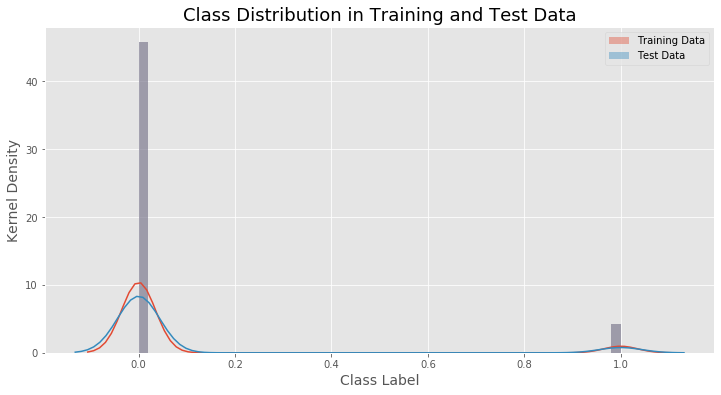

In [13]:
plt.figure(figsize=(12, 6))
sns.distplot(y_train)
sns.distplot(y_test)
plt.legend(['Training Data', 'Test Data'])
plt.xlabel('Class Label', fontsize=14)
plt.ylabel('Kernel Density', fontsize=14)
plt.title('Class Distribution in Training and Test Data', fontsize=18);

### Interpretation

This isn't a great plot. 
- For starters, we're not interested in class labels other than 0.0 and 1.0, but the `distplot` command treats class label as a continuous random variable.
- The histograms also overlap, which means its difficult to see whether the bars representing Training Data's class distribution is lower than or equal to that of Test Data.
- Thirdly, it isn't readily interpretable. I have no idea what Kernel Density is. 

### Making Bar Graphs of Class Label Counts

In [14]:
# Dictionaries of raw counts of class labels
raw_counts = {
    'train': {
        '0': np.count_nonzero(y_train == 0),
        '1': np.count_nonzero(y_train == 1)
    }, 
    'test': {
        '0': np.count_nonzero(y_test == 0),
        '1': np.count_nonzero(y_test == 1)
    }
}

In [15]:
# Repeat for normalized counts
NUM_TRAIN = len(y_train)
NUM_TEST = len(y_test)
NUM_SAMPLES = len(y)

normed_counts = {
    'train': {
        '0': np.count_nonzero(y_train == 0) / NUM_TRAIN,
        '1': np.count_nonzero(y_train == 1) / NUM_TRAIN
    }, 
    'test': {
        '0': np.count_nonzero(y_test == 0) / NUM_TEST,
        '1': np.count_nonzero(y_test == 1) / NUM_TEST
    }
}

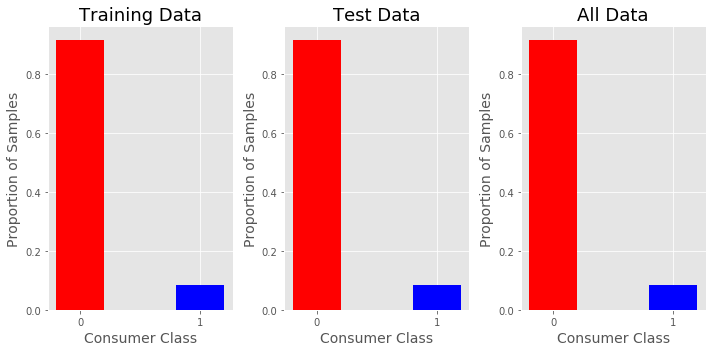

In [16]:
# Comparing train, test, and original data in 3 side-by-side graphs
fig, axes = plt.subplots(ncols=3, figsize=(10, 5), sharey=False)

# First plot - Training Data
plt.sca(axes[0])
plt.bar(x=normed_counts['train'].keys(), height=normed_counts['train'].values(), 
       color=['red', 'blue'], width=0.4)
plt.xlabel('Consumer Class', fontsize=14)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('Training Data', fontsize=18)

# Second plot - Test Data
plt.sca(axes[1])
plt.xlabel('Consumer Class', fontsize=14)
plt.bar(x=normed_counts['test'].keys(), height=normed_counts['test'].values(), 
       color=['red', 'blue'], width=0.4)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('Test Data', fontsize=18)


# Third plot - All data
plt.sca(axes[2])
plt.xlabel('Consumer Class', fontsize=14)
plt.bar(x=normed_counts['test'].keys(), 
       height=[np.count_nonzero(y == 0) / NUM_SAMPLES, 
               np.count_nonzero(y == 1) / NUM_SAMPLES], 
       color=['red', 'blue'], width=0.4)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('All Data', fontsize=18)
plt.tight_layout()

Have confirmed that the `stratify` argument in `train_test_split` has worked as expected: there are equal proportions of both the positive and negative classes in both the training and test data.

Furthermore, these proportions are exactly the same as in the entire dataset prior to the train/test split.

## First Model

### Training

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
logReg_1 = LogisticRegression()

In [10]:
logReg_1.fit(X_train, y_train)

/Users/saadmashkoor/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/saadmashkoor/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [11]:
# Did it learn one parameter for each day?
print("Number of parameters learnt: ", len(logReg_1.coef_[0]))

Number of parameters learnt:  1034


### Evaluation

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [13]:
y_pred = logReg_1.predict(X_test)

In [14]:
confusion_matrix(y_test, y_pred)

array([[9304,  385],
       [ 792,  112]])

In [15]:
print(classification_report(y_test, y_pred, target_names=['Regular', 'Thieves']))

              precision    recall  f1-score   support

     Regular       0.92      0.96      0.94      9689
     Thieves       0.23      0.12      0.16       904

   micro avg       0.89      0.89      0.89     10593
   macro avg       0.57      0.54      0.55     10593
weighted avg       0.86      0.89      0.87     10593



In [16]:
roc_auc_score(y_test, y_pred)

0.5420790112316037

In [72]:
precision, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=1)

In [73]:
len(precision)

3

In [74]:
len(recall)

3

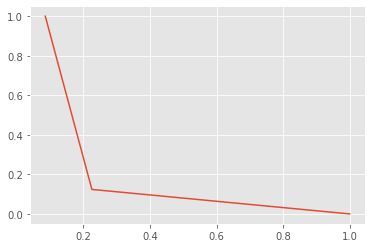

In [75]:
plt.plot(precision, recall)

In [19]:
from tensorflow.compat.v1.metrics import average_precision_at_k

In [24]:
# Number of samples used for mean average precision
K1 = 100
K2 = 200

In [28]:
# Confirming both pred and test have enough labels for MAP computation
assert len(y_test) >= np.max([K1, K2])
assert len(y_pred) >= np.max([K1, K2])

In [46]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [47]:
# Disabling Eager Execution for MAP
tf.compat.v1.disable_eager_execution()

In [60]:
_, m_ap_LR_100 = average_precision_at_k(y_test, y_pred, k=K1)

## Starting Over

In [10]:
def get_classification_result(y_pred, y_true, classifier_name=None):
    """Custom function to display classification results"""
    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves']))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    conf_mat = pd.DataFrame(data=confusion_matrix(y_true, y_pred))
    conf_mat.index = ['True 0', 'True 1']
    conf_mat.columns = ['Predicted 0', 'Predicted 1']
    cm = light_palette('blue', as_cmap=True)
    conf_mat_display = conf_mat.style.background_gradient(cmap=cm)
    display(conf_mat_display)
    
    # Display ROC 
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right')
    
    if classifier_name is not None:
        plt.title(f'ROC Curve - {classifier_name}', fontsize=14)

In [11]:
# Creating a Data Pipeline
from sklearn.pipeline import Pipeline

# For transformer class
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.base import BaseEstimator, TransformerMixin

In [12]:
# Creating a custom transformer 
class MyFeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scalingStrategy='StandardScaler'):
        """Initialize this transformer with an instance of the scaler you wish to use"""
        # Initialise dictionary of all possible scaling strategies
        self.scalingStrategies = {
            'StandardScaler': StandardScaler(),
            'MinMaxScaler': MinMaxScaler(),
            'MaxAbsScaler': MaxAbsScaler(),
            'RobustScaler': RobustScaler(),
            'ScaleByConsumer': Normalizer(),
        }
        self.scaler = self.scalingStrategies[scalingStrategy]
        
    def fit(self, X, y=None):
        # Do nothing for now
        return self.scaler.fit(X, y)
    
    def transform(self, X, y=None):
        scaled_features = self.scaler.transform(X, y)

In [13]:
pipeline = Pipeline([
    ('featureScaler', MyFeatureScaler())
])

In [14]:
scaledFeatures = pipeline.fit_transform(X_train, y_train)

Text(0, 0.5, 'Maximum Feature Value (Post Standard Scaling)')

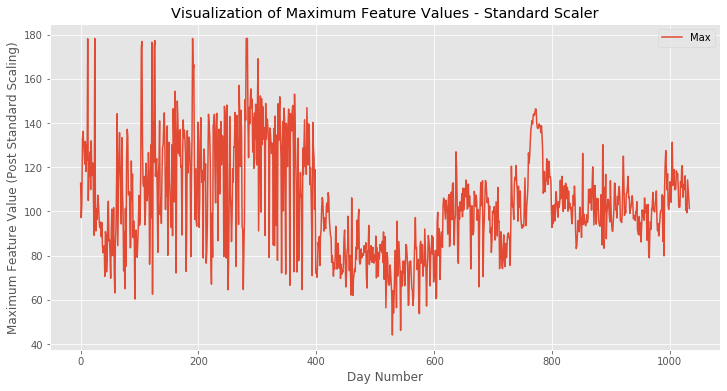

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(scaledFeatures).max(), label='Max')
plt.legend()
plt.title('Visualization of Maximum Feature Values - Standard Scaler')
plt.xlabel('Day Number')
plt.ylabel('Maximum Feature Value (Post Standard Scaling)')

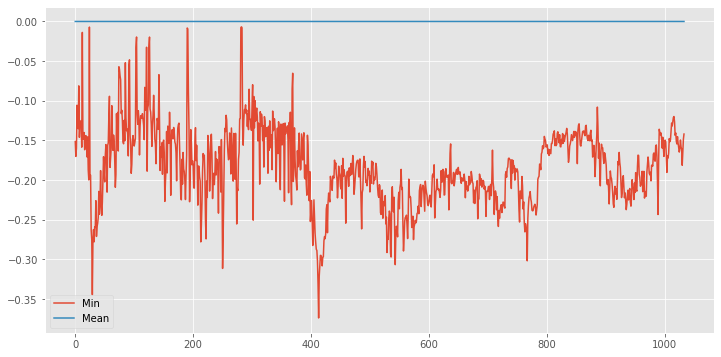

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(scaledFeatures).min(), label='Min')
plt.plot(pd.DataFrame(scaledFeatures).mean(), label='Mean')
plt.legend()

Minimum and mean values look fine. But maximum values do not. Is this a consequence of outliers being identified by consumer and not by day?

In [17]:
scaledByConsumer = Pipeline([
    ('featureScaler', MyFeatureScaler('ScaleByConsumer'))
]).fit_transform(X_train, y_train)

In [18]:
def visualize_feature_distribution(features, titleStr, sameGraph=False, withSNS=False):
    plt.tight_layout() 
    
    if withSNS:
        plt.figure(figsize=(10, 6))
        distplot(features.ravel(), kde=False) # KDE takes a LOOOOOONG TIME
        plt.xlabel('Feature Value', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(str('Distribution of Feature Values: ' + titleStr), fontsize=18)
        
    else:
        data = pd.DataFrame(features)
        if sameGraph:
            title = 'Feature Distribution: ' + titleStr
            plt.figure(figsize=(12, 6))
            plt.plot(data.max(), label='Max')
            plt.plot(data.min(), label='Min')
            plt.plot(data.mean(), label='Mean')
            plt.fill_between(data.mean() + data.std(), data.mean() - data.std())

            plt.legend(loc='lower right')
            plt.xlabel('Day Number', fontsize=14)
            plt.ylabel('Feature Values', fontsize=14)
            plt.title(title, fontsize=18)

        else: 
            title_1 = 'Maximum Feature Values: ' + titleStr
            title_2 = 'Minimum/Mean Feature Values: ' + titleStr

            plt.subplot(121)
            plt.plot(pd.DataFrame(features).max(), label='Maximum')
            plt.xlabel('Day Number', fontsize=14)
            plt.ylabel('Feature Values', fontsize=14)
            plt.title(title_1, fontsize=18)

            plt.subplot(122)
            plt.plot(pd.DataFrame(features).min(), label='Minimum')
            plt.plot(pd.DataFrame(features).mean(), label='Mean')
            plt.xlabel('Day Number', fontsize=14)
            plt.ylabel('Feature Values', fontsize=14)
            plt.title(title_2, fontsize=18)

<Figure size 432x288 with 0 Axes>

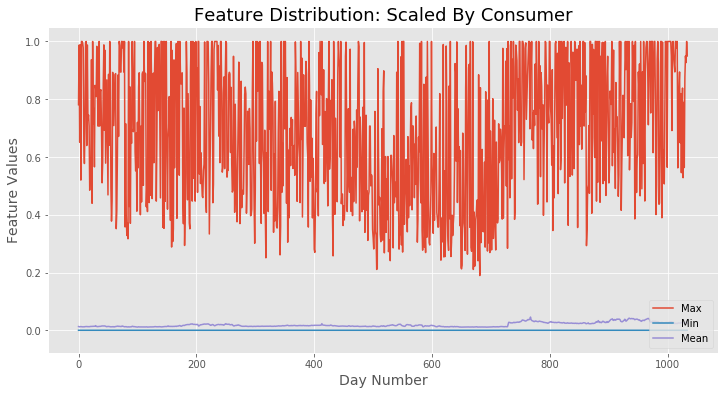

In [19]:
visualize_feature_distribution(scaledByConsumer, titleStr='Scaled By Consumer', sameGraph=True)

This looks good. No feature value exceeds 1.0 when scaled on a consumer basis.

<Figure size 432x288 with 0 Axes>

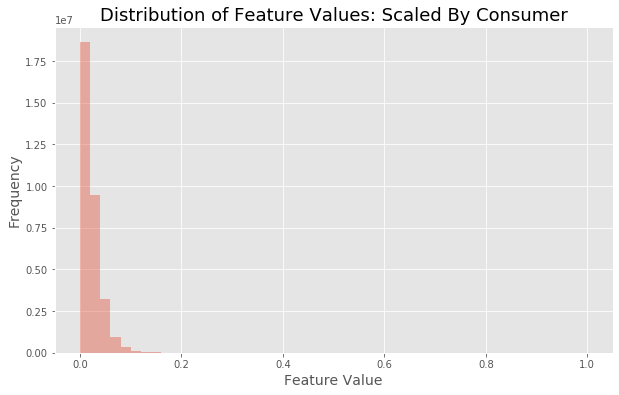

In [20]:
visualize_feature_distribution(scaledByConsumer, 'Scaled By Consumer', withSNS=True)

This looks alarming. Why are majority of the features near zero? Why isn't this distribution more Gaussian? Why is it so skewed? 
- Maybe because on most days, users will tend to use closeer to the minimum kWh rather than the maximum kWh?
- Also because the preprocessing has replaced a lot of feature values with 0 in case of missing values. Is this a sparse matrix?

In [21]:
from seaborn import heatmap

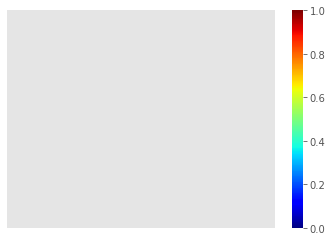

In [24]:
heatmap(scaledByConsumer, cmap='jet', xticklabels=False, yticklabels=False)

I give up. I'm just going to train a model.

## First Logistic Regression Model

In [25]:
from sklearn.linear_model import LogisticRegressionCV

In [26]:
# Using default parameters for now
logRegCV = LogisticRegressionCV()

In [28]:
logRegCV.fit(scaledByConsumer, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [30]:
probas = logRegCV.predict_proba(X_test)
y_pred = logRegCV.predict(X_test)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.96      0.22      0.36      9689
         Thieves       0.10      0.91      0.18       904

       micro avg       0.28      0.28      0.28     10593
       macro avg       0.53      0.57      0.27     10593
    weighted avg       0.89      0.28      0.35     10593

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,2179,7510
True 1,81,823


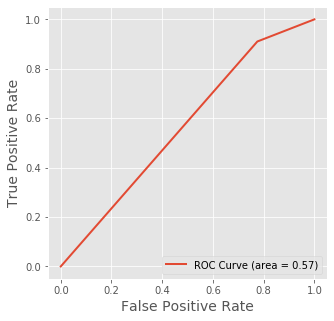

In [34]:
get_classification_result(y_pred, y_test)